In [91]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib.ticker import AutoMinorLocator

In [92]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import RocCurveDisplay

import time
from joblib import dump

In [100]:
def fit_eval(clf, X_train, y_train, X_test, y_test, name):
    print(f"Fitting {name} ...")
    start_tic = time.time()
    clf.fit(X_train, y_train)
    print(f"Fitting takes: {(time.time() - start_tic):.3f} s")
    
    # Get the best classifier from the grid search
    # best_clf_rf = grid_search.best_estimator_
    
    # Make predictions
    y_pred_proba = clf.predict_proba(X_test)[:, 1]
    
    # Calculate ROC AUC score
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    print("ROC AUC Score:", roc_auc)

    display = RocCurveDisplay.from_predictions(
        y_test,
        y_pred_proba,
        color="darkorange")
    
    _ = display.ax_.set(
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title=f"{name} ROC curve:",
        
    )
    
    return clf

In [94]:
train_data = pd.read_csv("data/train_wo_aug_set.csv")
test_data = pd.read_csv("data/test_wo_aug_set.csv")

train_aug_data = pd.read_csv("data/train_set.csv")
test_aug_data = pd.read_csv("data/test_set.csv")

In [106]:
indexes = [
    "h_l",
    "all",
]

names = [
    "RF_classifier",
    "RBF-SVM_classifier",
    "MLP_classifier-1L",
    "MLP_classifier-2L_s",
    "MLP_classifier-2L_L",
]

classifiers = [
    RandomForestClassifier(max_depth=10, 
                           min_samples_leaf=4, min_samples_split=10, 
                           n_estimators=200, random_state=42),
    SVC(gamma='auto', 
        probability=True, random_state=42),
    MLPClassifier(hidden_layer_sizes=(128), 
                  max_iter=1500, random_state=42),
    MLPClassifier(hidden_layer_sizes=(128, 32), 
                  max_iter=1000, random_state=42),
    MLPClassifier(hidden_layer_sizes=(256, 64), 
                  max_iter=1000, random_state=42),
]


datasets = [
    [train_data.drop(["mark"], axis=1).to_numpy(), test_data.drop(["mark"], axis=1).to_numpy(),
     train_data["mark"].to_numpy(), test_data["mark"].to_numpy(), "wo_aug"],
    [train_aug_data.drop(["mark"], axis=1).to_numpy(), test_aug_data.drop(["mark"], axis=1).to_numpy(),
     train_aug_data["mark"].to_numpy(), test_aug_data["mark"].to_numpy(), "aug"],
]

Fitting RF_classifier ...
Fitting takes: 0.232 s
ROC AUC Score: 0.988552807486631
Fitting RF_classifier ...
Fitting takes: 0.238 s
ROC AUC Score: 0.9985257985257985
Fitting RBF-SVM_classifier ...
Fitting takes: 0.048 s
ROC AUC Score: 0.9788602941176471
Fitting RBF-SVM_classifier ...
Fitting takes: 0.070 s
ROC AUC Score: 0.9957739557739558
Fitting MLP_classifier-1L ...
Fitting takes: 1.769 s
ROC AUC Score: 0.9912544563279857
Fitting MLP_classifier-1L ...
Fitting takes: 3.057 s
ROC AUC Score: 0.9999017199017199
Fitting MLP_classifier-2L_s ...
Fitting takes: 1.714 s
ROC AUC Score: 0.9894719251336899
Fitting MLP_classifier-2L_s ...
Fitting takes: 1.539 s
ROC AUC Score: 0.9997051597051597
Fitting MLP_classifier-2L_L ...
Fitting takes: 2.595 s
ROC AUC Score: 0.9885806595365418
Fitting MLP_classifier-2L_L ...
Fitting takes: 2.411 s
ROC AUC Score: 0.9998034398034398
Fitting RF_classifier ...
Fitting takes: 0.347 s
ROC AUC Score: 0.8389937306731055
Fitting RF_classifier ...
Fitting takes: 0.376

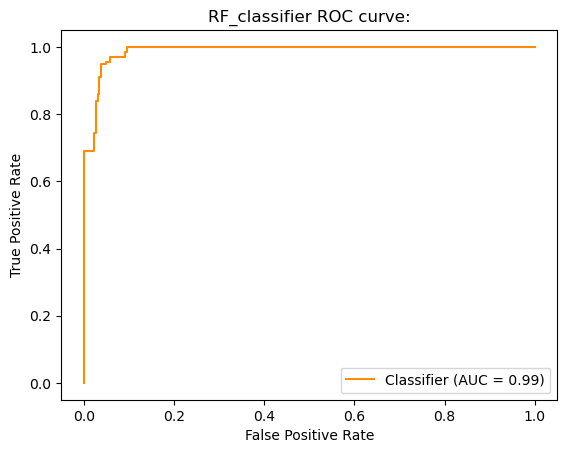

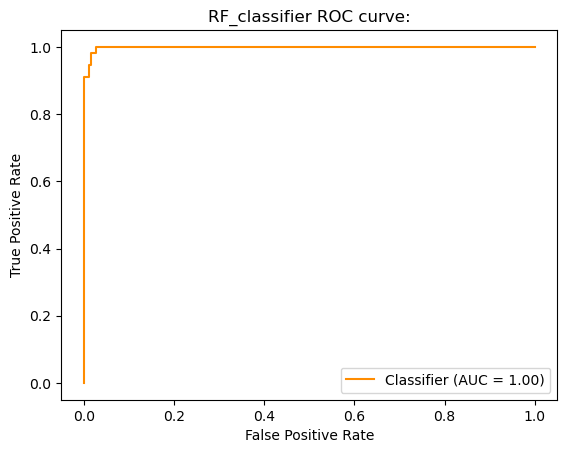

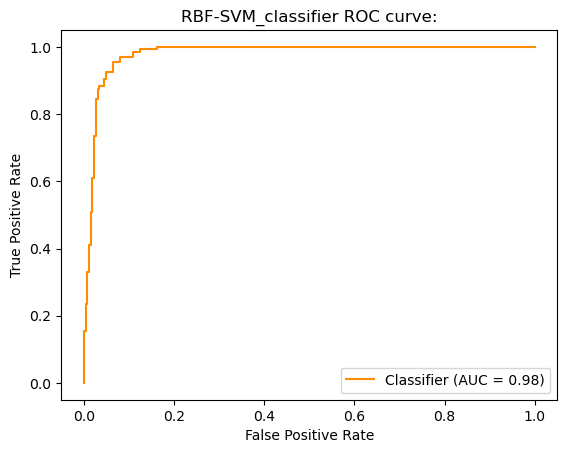

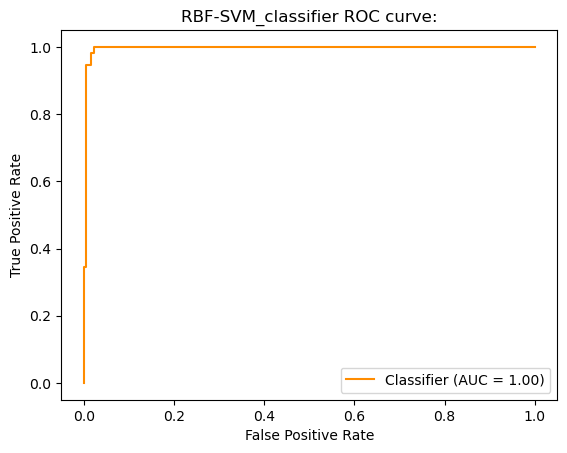

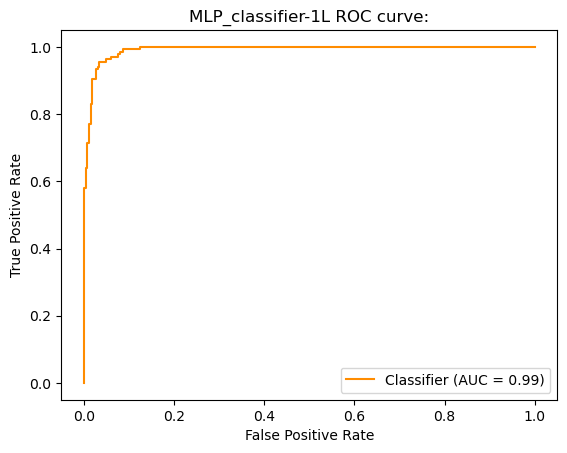

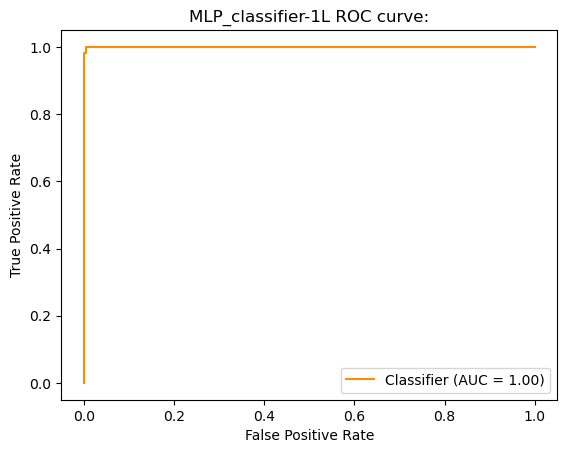

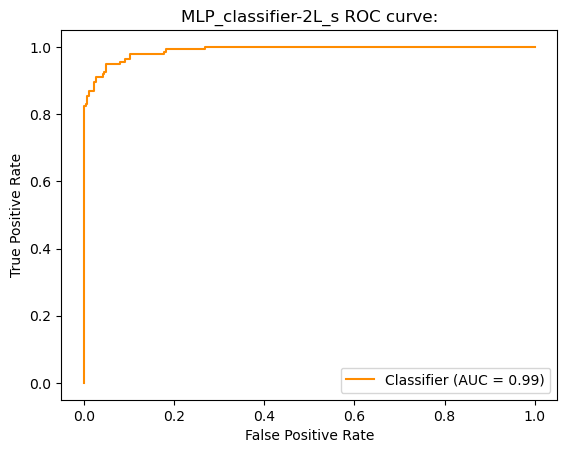

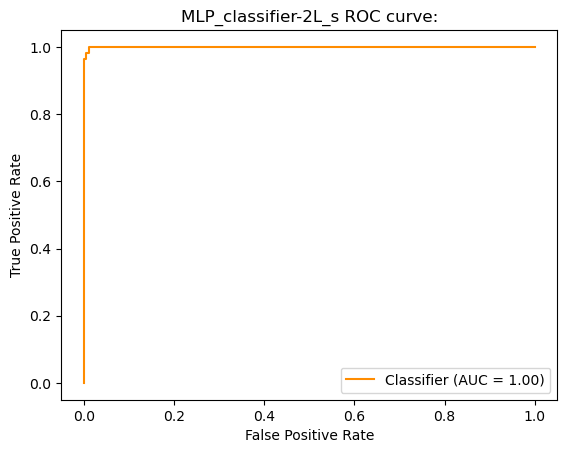

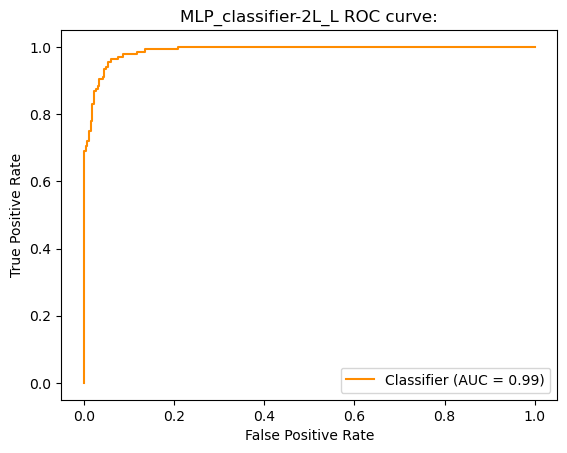

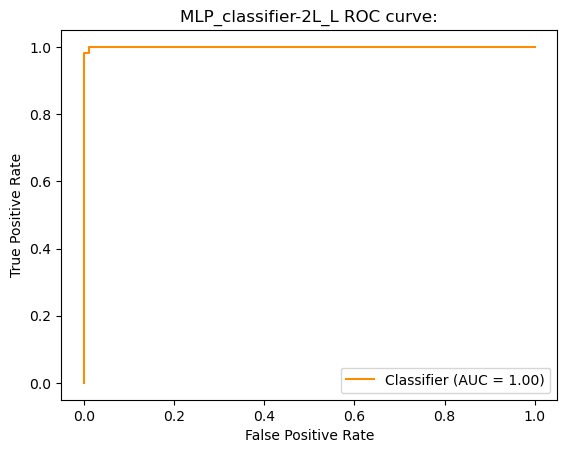

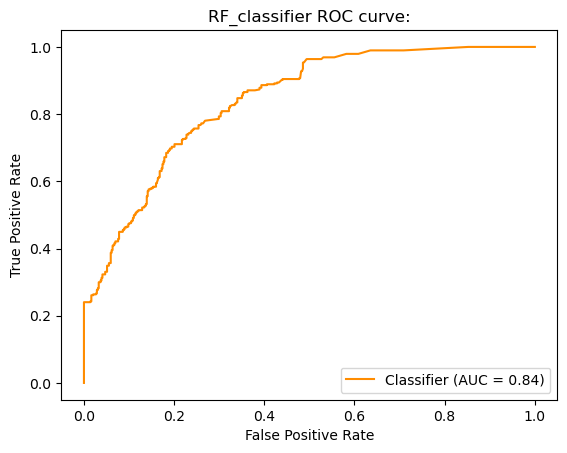

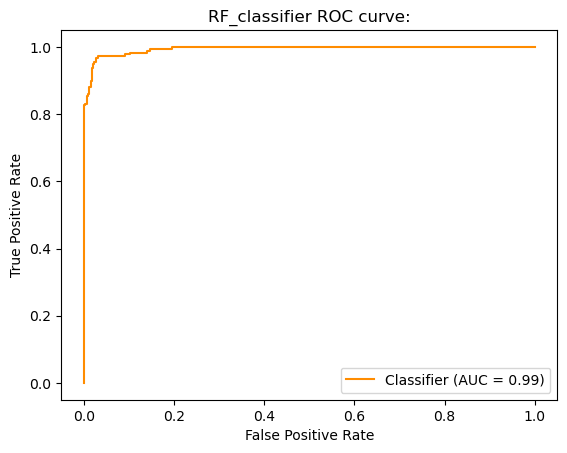

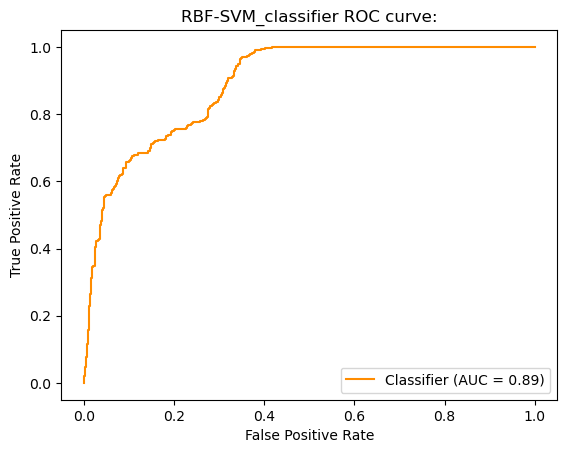

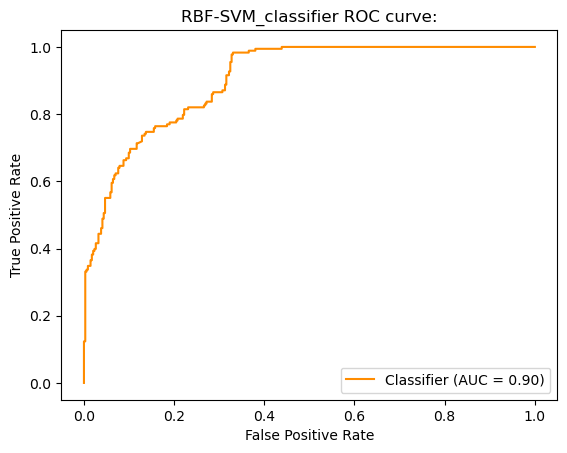

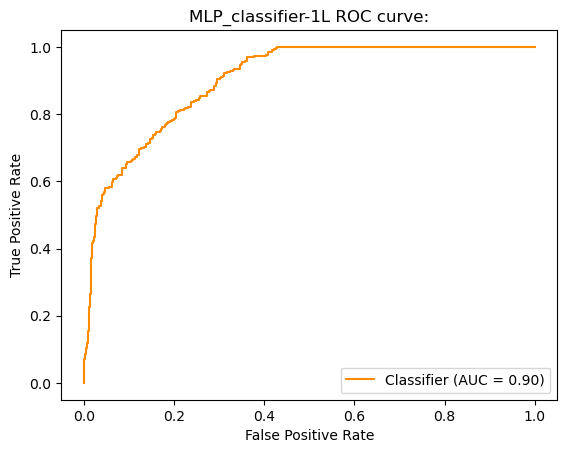

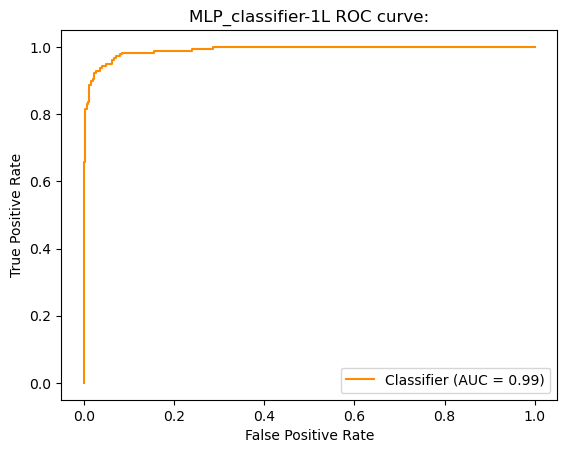

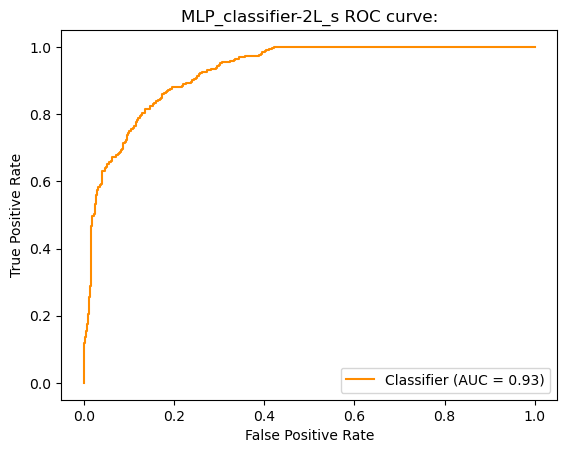

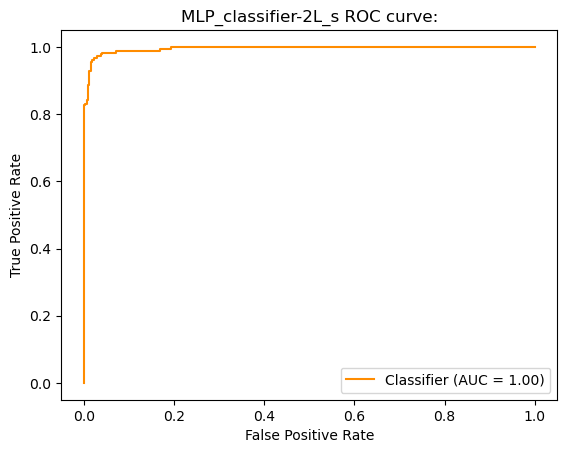

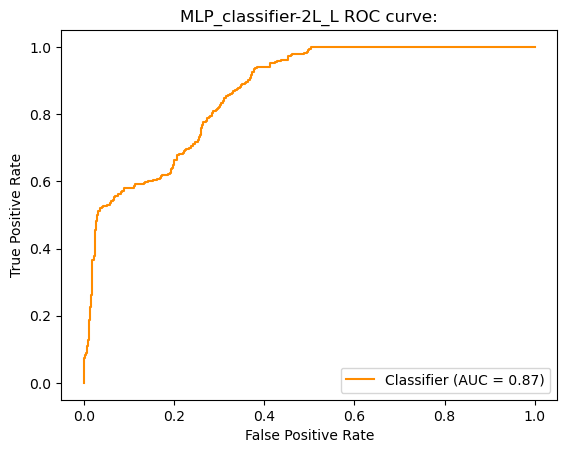

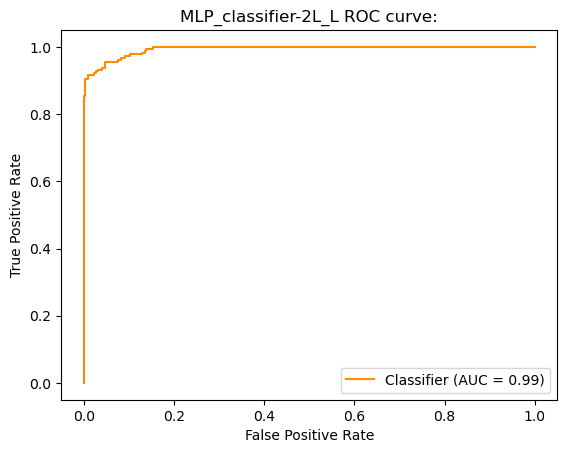

In [108]:
dir = "../Modeling Piling-Ballon Mode/models/"  # "models/"

for ds_cnt, ds in enumerate(datasets):
    X_train, X_test, y_train, y_test, name_ds = ds

    X, y = np.concatenate([X_train, X_test]), np.concatenate([y_train, y_test])
    X_train_, X_test_, y_train_, y_test_ = train_test_split(X, y, test_size=0.2, random_state=42)

    for name, clf in zip(names, classifiers):
        clf_pl_1 = make_pipeline(StandardScaler(), clf)
        fit_eval(clf_pl_1, X_train, y_train, X_test, y_test, name)
        
        clf_pl_2 = make_pipeline(StandardScaler(), clf)
        fit_eval(clf_pl_2, X_train_, y_train_, X_test_, y_test_, name)

        dump(clf_pl_1, f'{dir}{name}-{name_ds}-{indexes[0]}.joblib')
        dump(clf_pl_2, f'{dir}{name}-{name_ds}-{indexes[1]}.joblib')

---
---

In [3]:
X_train, X_test, y_train, y_test = train_data.drop(["mark"], axis=1).to_numpy(), test_data.drop(["mark"], axis=1).to_numpy(), train_data["mark"].to_numpy(), test_data["mark"].to_numpy()
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1725, 6) (875, 6) (1725,) (875,)


In [89]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

clf_rf = RandomForestClassifier(random_state=42)
clf_rf = clf_rf.set_params({'max_depth': 10,'min_samples_leaf': 4,'min_samples_split': 10,'n_estimators': 200})
# grid_search = GridSearchCV(clf_rf, param_grid, cv=5, scoring='roc_auc')

clf_rbf = make_pipeline(StandardScaler(), SVC(gamma='auto', probability=True, random_state=42))

print("Fitting RFC...")
start_tic = time.time()
clf_rf.fit(X_train_, y_train_)
print(f"Fitting takes: {(time.time() - start_tic):.3f} s")

# Get the best classifier from the grid search
# best_clf_rf = grid_search.best_estimator_

# Make predictions
y_pred_proba = clf_rf.predict_proba(X_test_)[:, 1]

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test_, y_pred_proba)
print("ROC AUC Score:", roc_auc)

Fitting RFC...
Fitting takes: 0.408 s
ROC AUC Score: 0.9939713515999737


In [10]:
# grid_search.best_params_

# {'max_depth': 10,
#  'min_samples_leaf': 4,
#  'min_samples_split': 10,
#  'n_estimators': 200}

{'max_depth': 10,
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'n_estimators': 200}

In [5]:
clf_linear = make_pipeline(StandardScaler(), SVC(kernel="linear", probability=True, random_state=42))
clf_rbf = make_pipeline(StandardScaler(), SVC(gamma='auto', probability=True, random_state=42))
clf_poly = make_pipeline(StandardScaler(), SVC(kernel="poly", probability=True, random_state=42))

In [86]:
print("Fitting RBF SVM...")
start_tic = time.time()
clf_rbf.fit(X_train_, y_train_)
print(f"Fitting takes: {(time.time() - start_tic):.3f} s")

print("Pedicting...")
y_pred_proba = clf_rbf.predict_proba(X_test_)[:, 1]

roc_auc = roc_auc_score(y_test_, y_pred_proba)
print("ROC AUC Score:", roc_auc)
print("-----")

display = RocCurveDisplay.from_predictions(
    y_test_,
    y_pred_proba,
    color="darkorange")

_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="ROC curve:",
)

Fitting RBF SVM...
Fitting takes: 0.597 s
Pedicting...
ROC AUC Score: 0.9033362901636113
-----


In [83]:
clf_mlp = make_pipeline(StandardScaler(), 
                        MLPClassifier(hidden_layer_sizes=(256, 64), max_iter=1000, random_state=42))
# , early_stopping=True

X, y = np.concatenate([X_train, X_test]), np.concatenate([y_train, y_test])

X_train_, X_test_, y_train_, y_test_ = train_test_split(X, y, test_size=0.2, random_state=42)

print("Fitting MLP Classifier...")
start_tic = time.time()
clf_mlp.fit(X_train_, y_train_)
print(f"Fitting takes: {(time.time() - start_tic):.3f} s")

print("Pedicting...")
y_pred_proba = clf_mlp.predict_proba(X_test_)[:, 1]

roc_auc = roc_auc_score(y_test_, y_pred_proba)
print("ROC AUC Score:", roc_auc)
print("-----")

Fitting MLP Classifier...
Fitting takes: 3.935 s
Pedicting...
ROC AUC Score: 0.9931992903607333
-----


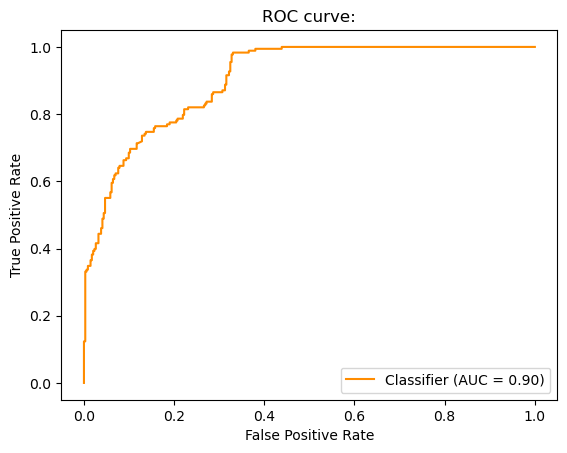

In [87]:
display = RocCurveDisplay.from_predictions(
    y_test_,
    y_pred_proba,
    color="darkorange")

_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="ROC curve:",
)

---

In [85]:
from joblib import dump

index = 3
dump(clf_mlp, f'../Modeling Piling-Ballon Mode/models/MLP_classifier_{index}.joblib')

['../Modeling Piling-Ballon Mode/models/MLP_classifier_3.joblib']

In [90]:
from joblib import dump

dump(clf_rf, 'models/RF_classifier_2.joblib')
# dump(clf_rbf, 'models/RBF-SVM_classifier_2.joblib')
# dump(clf_poly, 'models/Poly-SVM_classifier.joblib')
# dump(clf_linear, 'models/Linear-SVM_classifier.joblib')

['models/RF_classifier_2.joblib']